# Load Libs

In [ ]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf
import seaborn as sns, keras
sns.set(style='white')

from collections import Counter
from sklearn.preprocessing import LabelEncoder, scale
from matplotlib import pyplot as plt

from collections import OrderedDict
from sklearn.metrics import roc_curve, auc
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Activation, Input, Dropout, Embedding, Flatten, Input
from keras.layers import dot, add, Lambda, Concatenate, multiply
from keras.optimizers import Adam, SGD, Adagrad
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences

np.set_printoptions(precision=4, suppress=True, linewidth=100)

# Data Preview

In [ ]:
ratings = pd.read_csv('https://storage.googleapis.com/allianz-course/data/ratings.csv')
movies = pd.read_csv('https://storage.googleapis.com/allianz-course/data/movies.csv')

In [ ]:
print(movies.shape)
movies.head()

In [ ]:
print(ratings.shape)
ratings.head()

In [ ]:
print(ratings.rating.describe(), '\n')
print(ratings.rating.value_counts())

## Observations
* rating的分數介於 0.5 ~ 5分, 最小差距為0.5

# Encode

In [ ]:
# Fit user id and movie id
uid_enc, mid_enc = LabelEncoder(), LabelEncoder()
uid_enc.fit(ratings.userId)
mid_enc.fit(movies.movieId)

# Encode user id and movie id to indexed real value
ratings["userId"] = uid_enc.transform(ratings.userId)
ratings["movieId"] = mid_enc.transform(ratings.movieId)
movies["movieId"] = mid_enc.transform(movies.movieId)

# Dictionary of movie id and title
mid_map = pd.Series(dict(zip(movies.movieId, movies.title)))

# Number of users, number of movies
n_users, n_movies = len(uid_enc.classes_), len(mid_enc.classes_)

# Split Train, Test Data
* 以4分為閥值, 4分以上為positive, 未滿4分為negative
* 每個user分positive, negative兩部分, 各取30%到valid data

In [ ]:
def split_ratings(data, pos_thres=4, test_ratio=0.3):
    """依照test_ratio切割movielens train test資料"""
    tr, te = [], []
    for u, df in data.groupby("userId"):
        if len(df) < 5: continue

        pos, neg = df.query("rating >= {}".format(pos_thres)), df.query("rating < {}".format(pos_thres))
        # Split positive part
        pos_len = int(len(pos) * (1 - test_ratio))
        tr_pos = pos[:pos_len]
        te_pos = pos[pos_len:]
        # Split negative part
        neg_len = int(len(neg) * (1 - test_ratio))
        tr_neg = neg[:neg_len]
        te_neg = neg[neg_len:]

        tr.append(tr_pos.append(tr_neg))
        te.append(te_pos.append(te_neg))
    return pd.concat(tr, ignore_index=True), pd.concat(te, ignore_index=True)

tr, te = split_ratings(ratings, 4, .3)

# Make Rating Matrix (Interaction Between Users and Movies)

In [ ]:
tr_rating_mat = np.zeros((n_users, n_movies))
# Valid data rating matrix
te_rating_mat = np.zeros((n_users, n_movies))

# Train rating matrix
for idx, r in tr.iterrows():
    tr_rating_mat[int(r.userId), int(r.movieId)] = r.rating
# Valid rating matrix    
for idx, r in te.iterrows():
    te_rating_mat[int(r.userId), int(r.movieId)] = r.rating
    
print('Shape of train interaction matrix: ', tr_rating_mat.shape)
print(tr_rating_mat, '\n')
print('Shape of test interaction matrix: ', te_rating_mat.shape)
print(te_rating_mat)

# Encode Movies Table

In [ ]:
def do_movies(movies):
    movies = movies.reset_index(drop=True)
    movies["genres"] = movies.genres.str.split("\|")
    genres_cnt = Counter()
    movies.genres.map(genres_cnt.update)
    genres_map = LabelEncoder()
    genres_map.fit( np.array(genres_cnt.most_common())[:, 0] )
    movies["genres"] = movies.genres.map(lambda lst: genres_map.transform(lst))
    
    movies["avg_rating"] = ratings.groupby("movieId").rating.mean()
    movies["avg_rating"] = scale(movies.avg_rating.fillna(movies.avg_rating.mean()))
    movies["freq_rating"] = ratings.groupby("movieId").size()
    movies["freq_rating"] = scale(movies.avg_rating.fillna(movies.freq_rating.median()))
    movies["year"] = movies.title.str.findall("\(\s*(\d+)\s*\)").map(lambda lst: int(lst[-1]) if len(lst) else None)
    movies["year"] = scale(movies.year.fillna(movies.year.mean()))

    return movies, genres_map

movies_encoded, genres_map = do_movies(movies)
n_genres = len(genres_map.classes_)
movies_encoded.head()

# Encode Users Statistics

In [ ]:
# user_encoded 
user_encoded = ratings.groupby('userId').rating.agg(['size', 'mean'])
user_encoded.columns = ['user_rating_freq', 'user_rating_mean']
user_encoded['user_rating_freq'] = scale(user_encoded.user_rating_freq)
user_encoded['user_rating_mean'] = scale(user_encoded.user_rating_mean)
user_encoded = user_encoded.reset_index()
user_encoded.head()

# 以leave one out方式產生 train data, test data
1. 每一筆資料有兩部分: [user query] + [item id]
2. 每一筆user query 包含所有user movie history, 除了當前的rating movie (candidate movie)
3. test data的user query來自於train data

In [11]:
def loo_preprocess(data, movies_encoded, train_hist=None, is_train=True):
    """以leave one out方式產生 train data, test data"""
    queue = []
    data = data.merge(movies_encoded, how="left", on="movieId")
    data = data.merge(user_encoded, how="left", on="userId")
    columns = ["user_id", "query_movie_ids", "query_movie_ids_len", "user_rating_freq", "user_rating_mean",
               "genres", "genres_len", "avg_rating", "freq_rating", "year", "candidate_movie_id",
               "rating"]
    for u, df in data.groupby("userId"):
        df = df.sort_values("rating", ascending=False)
        if is_train:
            fav_movies = set(df.query("rating >= 4").movieId)
        else:
            fav_movies = set(train_hist.query(f"userId == {u} and rating >= 4").movieId)
        for i, (_, r) in enumerate(df.iterrows()):
            queries = list(fav_movies - set([int(r.movieId)]))
            # 對於multivalent的欄位, 需要增加一個column去描述該欄位的長度
            queue.append([int(r.userId),
                          queries,
                          len(queries),
                          r.user_rating_freq,
                          r.user_rating_mean,
                          r.genres,
                          len(r.genres),
                          r.avg_rating,
                          r.freq_rating,
                          r.year, 
                          int(r.movieId), 
                          r.rating])
    return pd.DataFrame(queue, columns=columns)

trProcessed = loo_preprocess(tr, movies_encoded)
teProcessed = loo_preprocess(te, movies_encoded, tr, is_train=False)
trProcessed.head()

,user_id,query_movie_ids,query_movie_ids_len,user_rating_freq,user_rating_mean,genres,genres_len,avg_rating,freq_rating,year,candidate_movie_id,rating
0,0,[1515],1,-0.558471,-2.351626,[8],1,1.102099,1.102099,-0.153507,931,4.0
1,0,[931],1,-0.558471,-2.351626,"[1, 6, 17]",3,0.830070,0.830070,-1.083561,1515,4.0
2,0,"[931, 1515]",2,-0.558471,-2.351626,"[9, 11, 15, 17]",4,0.006851,0.006851,0.001502,1083,3.5
3,0,"[931, 1515]",2,-0.558471,-2.351626,"[3, 4, 8, 13]",4,0.466777,0.466777,-2.633649,833,3.0
4,0,"[931, 1515]",2,-0.558471,-2.351626,[17],1,0.288261,0.288261,0.208180,859,3.0


In [12]:
teProcessed.head()

,user_id,query_movie_ids,query_movie_ids_len,user_rating_freq,user_rating_mean,genres,genres_len,avg_rating,freq_rating,year,candidate_movie_id,rating
0,0,"[931, 1515]",2,-0.558471,-2.351626,"[1, 2, 16]",3,0.212350,0.212350,-0.515195,1665,4.0
1,0,"[931, 1515]",2,-0.558471,-2.351626,"[2, 5]",2,0.252353,0.252353,-0.618534,1708,3.0
2,0,"[931, 1515]",2,-0.558471,-2.351626,"[5, 19]",2,0.731949,0.731949,-0.928552,2925,3.0
3,0,"[931, 1515]",2,-0.558471,-2.351626,"[8, 11, 16, 17]",4,0.115535,0.115535,-0.308516,1962,2.5
4,0,"[931, 1515]",2,-0.558471,-2.351626,"[1, 2, 9]",3,-0.102010,-0.102010,-0.205177,1743,2.0


## Data Function
1. 由於tensorflow placeholder不支援變動長度的columns, 需透過padding zero(補零)帶入
2. 每個變動長度的column, 需要再給lens描述每一筆資料的長度, ex: query_movie_ids, query_movie_ids_len

In [13]:
def get_minibatches_idx(n, batch_size, shuffle=False):
    idx_list = np.arange(n, dtype="int32")
    if shuffle:
        np.random.shuffle(idx_list)
    minibatches = []
    minibatch_start = 0
    for i in range(n // batch_size):
        minibatches.append(idx_list[minibatch_start : minibatch_start + batch_size])
        minibatch_start += batch_size

    if (minibatch_start != n):
        # Make a minibatch out of what is left
        minibatches.append(idx_list[minibatch_start:])
    return minibatches

def do_multi(df, multi_cols):
    pad = pad_sequences
    df = df.copy()
    for colname in multi_cols:
        lens = df[colname].map(len)
        df[colname] = list(pad(df[colname], padding="post", maxlen=lens.max()))
    return df

feats = ["query_movie_ids", "query_movie_ids_len", "user_rating_freq", "user_rating_mean",
         "genres", "genres_len", "avg_rating", "freq_rating", "year", "candidate_movie_id", 'global']
multi_cols = ["query_movie_ids", 'genres']
label = 'rating'

def dataFn(data, n_batch=128, shuffle=False):
    pad = pad_sequences
    def fn():
        while True:
            dataInner = data.copy()
            indices = get_minibatches_idx(len(dataInner), n_batch, shuffle=shuffle)
            for ind in indices:
                ret = do_multi(dataInner.iloc[ind], multi_cols)
                # ret = pd.DataFrame(ret)
                ret['global'] = 0
                yield [np.stack(ret[col].values) if col in multi_cols else ret[col][:, None]
                       for col in feats], ret.rating.values[:, None]
    return fn

for data, label in dataFn(trProcessed, n_batch=5, shuffle=True)():
    break

for name, col in zip(feats, data):
    print(f'{name}\n{col}\n')
print(f'label\n{label}')

query_movie_ids
[[4231  520 6152 ...    0    0    0]
 [4098 4102 4105 ... 4050 2009 4079]
 [1024 3074 1026 ...    0    0    0]
 [1024  642  899 ...    0    0    0]
 [   0 1024 1026 ...    0    0    0]]

query_movie_ids_len
[[ 38]
 [720]
 [344]
 [ 56]
 [205]]

user_rating_freq
[[0.0734]
 [9.7032]
 [5.1545]
 [2.4408]
 [2.0253]]

user_rating_mean
[[-0.8142]
 [-0.6174]
 [-0.9945]
 [-2.4518]
 [-1.0073]]

genres
[[ 5  0  0  0  0]
 [ 8  0  0  0  0]
 [ 5  0  0  0  0]
 [ 1  2  5 15 17]
 [ 1  2  5 15 17]]

genres_len
[[1]
 [1]
 [1]
 [5]
 [5]]

avg_rating
[[0.8139]
 [1.9429]
 [0.0605]
 [0.2538]
 [0.2538]]

freq_rating
[[0.8139]
 [1.9429]
 [0.0605]
 [0.2538]
 [0.2538]]

year
[[-0.3085]
 [-0.7735]
 [-0.4635]
 [ 0.1048]
 [ 0.1048]]

candidate_movie_id
[[2340]
 [5375]
 [2337]
 [ 344]
 [ 344]]

global
[[0]
 [0]
 [0]
 [0]
 [0]]

label
[[4.5]
 [5. ]
 [4. ]
 [2.5]
 [2. ]]


In [14]:
tmp = pd.DataFrame()
for col, val in zip(feats, data):
    if col in multi_cols:
        tmp[col] = list(val)
    else:
        tmp[col] = val.ravel()

tmp['rating'] = label.ravel()
tmp

,query_movie_ids,query_movie_ids_len,user_rating_freq,user_rating_mean,genres,genres_len,avg_rating,freq_rating,year,candidate_movie_id,global,rating
0,"[4231, 520, 6152, 524, 6158, 2062, 912, 2063, ...",38,0.073414,-0.814226,"[5, 0, 0, 0, 0]",1,0.813894,0.813894,-0.308516,2340,0,4.5
1,"[4098, 4102, 4105, 4108, 4109, 15, 16, 20, 206...",720,9.703174,-0.617415,"[8, 0, 0, 0, 0]",1,1.942914,1.942914,-0.773543,5375,0,5.0
2,"[1024, 3074, 1026, 5, 1030, 1032, 10, 13, 1037...",344,5.154465,-0.994522,"[5, 0, 0, 0, 0]",1,0.060501,0.060501,-0.463525,2337,0,4.0
3,"[1024, 642, 899, 263, 266, 2442, 535, 154, 284...",56,2.440820,-2.451830,"[1, 2, 5, 15, 17]",5,0.253790,0.253790,0.104841,344,0,2.5
4,"[0, 1024, 1026, 1030, 6, 1032, 521, 522, 1035,...",205,2.025334,-1.007336,"[1, 2, 5, 15, 17]",5,0.253790,0.253790,0.104841,344,0,2.0


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

# Model of Matrix Factorization with Movies Histories

## Build Model Function

In [84]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_query = Input([None], dtype='int32', name='inp_query')
    inp_query_len = Input([1], dtype='int32', name='inp_query_len')
    inp_u_freq = Input([1], dtype='float32', name='inp_u_freq')
    inp_u_mean = Input([1], dtype='float32', name='inp_u_mean')
    inp_genres = Input([None], dtype='int32', name='inp_genres')
    inp_genres_len = Input([1], dtype='int32', name='inp_genres_len')
    inp_avg_rating = Input([1], dtype='float32', name='inp_avg_rating')
    inp_freq_rating = Input([1], dtype='float32', name='inp_freq_rating')
    inp_year = Input([1], dtype='float32', name='inp_year')
    inp_movie = Input([1], dtype='int32', name='inp_movie')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32', name='inp_global')
    
    # User, movie, genres embedding
    emb_query = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform', 
                          embeddings_regularizer=regularizers.l2(reg))(inp_query)
    emb_genres = Embedding(n_genres, 8, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_genres)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=regularizers.l2(reg))(inp_movie)
    
    # User side
    def sqrtn(x):
        qry, lens = x
        lens = tf.reshape(lens, [-1])
        weights = tf.nn.l2_normalize(tf.sequence_mask(lens, dtype=tf.float32), 1)
        weights = tf.expand_dims(weights, -1)
        return tf.reduce_sum(qry * weights, 1)
    emb_query = Lambda(sqrtn, name='emb_query')([emb_query, inp_query_len])
    emb_query = Concatenate(1)([emb_query, inp_u_freq, inp_u_mean])
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_query)
    emb_query = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='user_impression')(emb_query)
    
    # Movie side
    emb_genres = Lambda(sqrtn, name='emb_genres')([emb_genres, inp_genres_len])
    emb_movie = Flatten(name='emb_movie')(emb_movie)
    emb_movie = Concatenate(1)([emb_movie, emb_genres, inp_avg_rating, inp_freq_rating, inp_year])
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg))(emb_movie)
    emb_movie = Dense(emb_size, activation='relu', kernel_regularizer=regularizers.l2(reg), name='movie_impression')(emb_movie)
    
    
    # Bias terms
    # Projection of emb_query to get bias
    b_user = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_user')(emb_query)
    # Projection of emb_movie to get bias
    b_movie = Dense(1, 
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(reg),
                   activation='linear', 
                   use_bias=False,
                   name='b_movie')(emb_movie)
    b_global = Flatten(name='b_global')(Embedding(1, 1, embeddings_initializer='glorot_uniform')(inp_global))
    
    # Implements the formulation
    nets = dot([emb_query, emb_movie], axes=1)
    nets = add([nets, b_user, b_movie, b_global])
    
    model = Model([inp_query, 
                   inp_query_len, 
                   inp_u_freq,
                   inp_u_mean,
                   inp_genres, 
                   inp_genres_len, 
                   inp_avg_rating,
                   inp_freq_rating,
                   inp_year,
                   inp_movie, 
                   inp_global], nets)
    model.summary()
    return model, Model([inp_movie, 
                         inp_genres, 
                         inp_genres_len, 
                         inp_avg_rating,
                         inp_freq_rating,
                         inp_year], emb_movie)

emb_size = 16
reg = 0.0005

K.clear_session()
model_mf_dnn, model_emb_movie = get_model(n_users, n_movies, emb_size, reg)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_query (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
inp_movie (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
inp_genres (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 16)     10736       inp_query[0][0]                  
__________________________________________________________________________________________________
inp_query_

# Training

## Use Callback Function
* keras.callbacks.ModelCheckpoint: 只存檔最好的結果, 是另一種防止overfitting的方式
    * save_best_only = True

Epoch 1/10
543/543 [==============================] - 7s 13ms/step - loss: 0.8376 - val_loss: 0.7832
Epoch 2/10
543/543 [==============================] - 7s 12ms/step - loss: 0.7770 - val_loss: 0.7588
Epoch 3/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7684 - val_loss: 0.7144
Epoch 4/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7615 - val_loss: 0.7873
Epoch 5/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7579 - val_loss: 0.7033
Epoch 6/10
543/543 [==============================] - 7s 12ms/step - loss: 0.7531 - val_loss: 0.7060
Epoch 7/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7485 - val_loss: 0.7347
Epoch 8/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7466 - val_loss: 0.7096
Epoch 9/10
543/543 [==============================] - 7s 12ms/step - loss: 0.7425 - val_loss: 0.7093
Epoch 10/10
543/543 [==============================] - 7s 13ms/step - loss: 0.7403 - val_lo

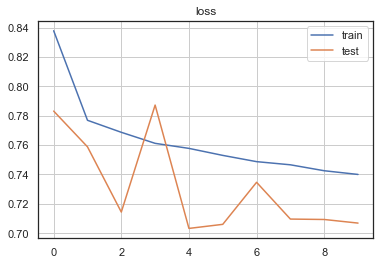

In [85]:
model_mf_dnn.compile(optimizer=SGD(lr=0.05), loss='mse')

batch_size = 128
epochs = 10
model_dir = "./model_mf_dnn"

tr_len = len(trProcessed)
te_len = len(teProcessed)
hist = model_mf_dnn.fit_generator(
    generator=dataFn(trProcessed, n_batch=batch_size, shuffle=True)(),
    steps_per_epoch=tr_len // batch_size + (1 if tr_len % batch_size else 0),
    validation_data=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    validation_steps=te_len // batch_size + (1 if te_len % batch_size else 0),
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint(filepath=model_dir, 
                               save_weights_only=True, 
                               save_best_only=True)]
)

# After training, load the best weights back
model_mf_dnn.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction

In [95]:
te_len = len(teProcessed)
pred = model_mf_dnn.predict_generator(
    generator=dataFn(teProcessed, n_batch=batch_size, shuffle=False)(),
    steps=te_len // batch_size + (1 if te_len % batch_size else 0)
).ravel()
print('Shape of test data: ', pred.shape)

Shape of test data:  (30605,)


# Metrics
* 定義4分以上為正向評價, 4分以下為負向評價

## RMSE 

In [96]:
te_len = len(teProcessed)
valis_steps = te_len // batch_size + (1 if te_len % batch_size else 0)

te_y = []
for i, (feat, label) in enumerate(dataFn(teProcessed, 
                                         n_batch=batch_size, 
                                         shuffle=False)(), 1):
    if i > valis_steps: break
    te_y += label.ravel().tolist()
    
te_y = np.array(te_y)
print("RMSE: ", np.sqrt(np.mean((pred - te_y)**2)))

RMSE:  0.8025473028349379


## AUC

auc: 0.8115914383744806


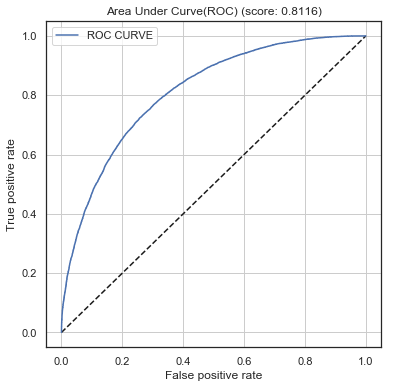

In [97]:
def draw_roc_curve(y, pred_proba):
    fpr, tpr, _ = roc_curve(y, pred_proba, pos_label=1)
    auc_scr = auc(fpr, tpr)
    print("auc:", auc_scr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Area Under Curve(ROC) (score: {:.4f})'.format(auc_scr))
    ax.legend(loc='best')
    plt.grid(True)
    plt.show()
    
draw_roc_curve(te.rating >= 4, pred / pred.max())

## Single User Rating Histogram

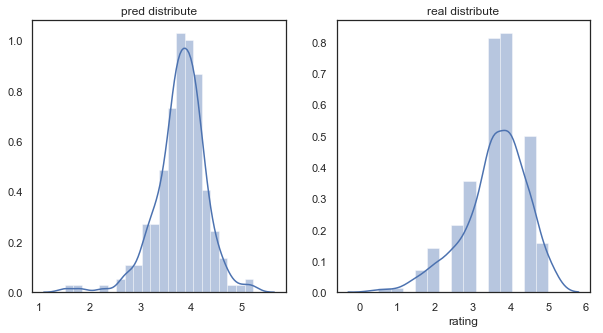

In [32]:
# user id from 0 ~ 670
uid = 22
tmp = teProcessed.query(f"user_id == {uid}")
single_pred = model_mf_dnn.predict_generator(
    generator=dataFn(tmp, n_batch=batch_size, shuffle=False)(),
    steps=len(tmp) // batch_size + (1 if len(tmp) % batch_size else 0)
).ravel()

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribute")
sns.distplot(single_pred, ax=ax[0])
ax[1].set_title("real distribute")
sns.distplot(te.query(f"userId == '{uid}'").rating, ax=ax[1])
plt.show()

## Single User Detail Table

In [33]:
# user id from 0 ~ 670
uid = 22
tmp = teProcessed.query(f"user_id == {uid}")
single_pred = model_mf_dnn.predict_generator(
    generator=dataFn(tmp, n_batch=batch_size, shuffle=False)(),
    steps=len(tmp) // batch_size + (1 if len(tmp) % batch_size else 0)
).ravel()

recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": tmp.candidate_movie_id,
              "title": mid_map[tmp.candidate_movie_id].values,
              "rating": tmp.rating.values,
              "predRating": single_pred},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.sort_values("rating", ascending=False)

,userId,movieId,title,rating,predRating
1224,22,4855,Kill Bill: Vol. 1 (2003),5.0,3.903784
1230,22,5016,Stolen Kisses (Baisers volés) (1968),5.0,4.412870
1225,22,6132,Crash (2004),5.0,4.098488
1234,22,4371,Adaptation (2002),5.0,3.917500
1232,22,4008,And Your Mother Too (Y tu mamá también) (2001),5.0,4.064291
1231,22,4432,City of God (Cidade de Deus) (2002),5.0,4.358509
1233,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,5.236749
1229,22,5761,Duel (1971),5.0,4.182854
1228,22,4419,"Hours, The (2002)",5.0,3.939949
1227,22,4417,Catch Me If You Can (2002),5.0,4.076881


In [34]:
recommDf.sort_values("predRating", ascending=False)

,userId,movieId,title,rating,predRating
1233,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,5.236749
1226,22,5623,Undertow (2004),5.0,5.144791
1283,22,4751,Ikiru (1952),4.0,4.972904
1296,22,3957,"Bad and the Beautiful, The (1952)",4.0,4.811474
1269,22,4724,Umberto D. (1952),4.5,4.698143
1331,22,5369,Viridiana (1961),3.5,4.682635
1316,22,5227,Zorba the Greek (Alexis Zorbas) (1964),4.0,4.675735
1281,22,6185,Last Days (2005),4.0,4.593620
1268,22,4241,Heaven (2002),4.5,4.578270
1322,22,5333,Sunrise: A Song of Two Humans (1927),4.0,4.558904


## Precision@K (K = 10)

### Before Computing Precision@K, See the Count Plot Below First

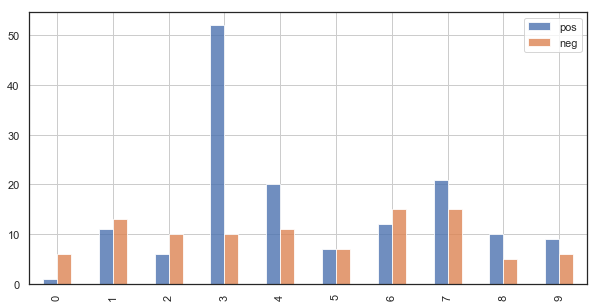

In [23]:
pos_ary, neg_ary = [], []
for label in te_rating_mat:
    label = label[label != 0]
    pos_ary.append(sum(label >= 4))
    neg_ary.append(sum(label < 4))
    
def draw_pos_neg(idx):
    pd.DataFrame(index=idx, 
                 data={"pos": np.array(pos_ary)[idx], 
                       "neg": np.array(neg_ary)[idx]})\
      .plot.bar(figsize=(10, 5), alpha=0.8)
    plt.grid(True)
    plt.show()

draw_pos_neg(np.arange(len(te_rating_mat))[0:10])

### Observations
1. 0號, 2號, 5號, 9號 user 正向評價數量 < 10, 就算model全部預測命中, 命中率也不會是 100%!
    ex: 0號user只有1個正向評價, 全部命中也只得到0.1的分數
2. 3號user正向評價是負向評價的5倍多, 就算亂猜, 中的機率也很高

In [24]:
def strict_condition(label):
    label = label[label != 0]
    pos, neg = sum(label >= 4), sum(label < 4)
    return len(label) >= 10 and pos <= neg and pos > 0

def norm_condition(label):
    label = label[label != 0]
    return sum(label >= 4) > 0 and sum(label < 4) > 0

_ = sum(np.sum(te_rating_mat >= 4, 1) < 10)
print("{} 個user正向評價總數小於10!".format(_))
print("rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [{}] 人".format(sum(strict_condition(label) for label in te_rating_mat)))
print("rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [{}] 人".format(sum(norm_condition(label) for label in te_rating_mat)))

266 個user正向評價總數小於10!
rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [209] 人
rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [669] 人


In [25]:
def precision_at_k(truth, pred_mat, condition_fn=None, k=10, label_thres=4):
    hits, total = 0, 0
    for label, pr in zip(truth, pred_mat):
        if not condition_fn(label): continue

        top_k_ind = (pr * (label != 0)).argsort()[::-1][:k]
        hits += sum(label[top_k_ind] >= label_thres)
        total += k
    return hits / total

In [26]:
pred_mat = np.zeros_like(te_rating_mat)
pred_mat[te.userId, te.movieId] = pred
    
print( "strict condition precision at 10: ", precision_at_k(te_rating_mat, pred_mat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(te_rating_mat, pred_mat, norm_condition, k=10) )

strict condition precision at 10:  0.5933014354066986
norm condition precision at 10:  0.6913303437967115


## NDCG: Normalized Discounted Cumulative Gain
1. A measure of ranking quality.
2. loop 每一位user, prediciton score排序後計算NDCG
    <br/>$$ DCG_p = \sum^p_{i = 1} \frac{2^{rel_i} - 1}{log_2(i + 1)} $$<br/>
3. IDCG: Ideal DCG, 為理想狀態下的DCG分數, 即model全部命中的DCG分數, 而NDCG: Normalized DCG, 公式如下
    <br/>$$ NDCG_p = \sum^p_{i = 1} \frac{DCG_p}{IDCG_p} $$<br/>
4. 所以NDCG是一個比值, 介於0 ~ 1之間

In [27]:
def all_user_ndcg(label_mat, pred_mat, cond_fn, label_thres=4, k=10):
    """avg of all user ndcg score"""
    tot_ndcg, actual_cnt = 0, 0
    for i, (label, score) in enumerate(zip(label_mat, pred_mat)):
        if not cond_fn(label): continue

        ndcg = single_user_ndcg(label, score, k=10)
        if ndcg is not None:
            tot_ndcg += ndcg
            actual_cnt += 1
    return tot_ndcg / actual_cnt

def single_user_ndcg(label, score, label_thres=4, k=10):
    """single user ndcg score"""
    nnz = label.nonzero()[0]
    # if np.sum(label >= label_thres) < k: return None
    label, score = label[nnz], score[nnz]
    label = (label >= label_thres).astype(int)
    return ndcg_score(label, score, k)

def ndcg_score(y_true, y_score, k=10, gains="exponential"):
    """Normalized discounted cumulative gain (NDCG) at rank k"""
    best = dcg_score(y_true, y_true, k, gains)
    actual = dcg_score(y_true, y_score, k, gains)
    return actual / best

def dcg_score(y_true, y_score, k=10, gains="exponential"):
    """Discounted cumulative gain (DCG) at rank k"""
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    # Highest rank is 1 so +2 instead of +1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)

In [28]:
pred_mat = np.zeros_like(te_rating_mat)
pred_mat[te.userId, te.movieId] = pred
    
strict_ndcg = all_user_ndcg(te_rating_mat, pred_mat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(te_rating_mat, pred_mat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

strict condition ndcg at 10:  0.7370813115899234
norm condition ndcg at 10:  0.833263535445938


In [93]:
movies[movies.title.str.contains("Toy")]

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1579,1579,Babes in Toyland (1961),Children|Fantasy|Musical
1780,1780,Toys (1992),Comedy|Fantasy
2479,2479,Babes in Toyland (1934),Children|Comedy|Fantasy|Musical
2506,2506,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3829,3829,"Toy, The (1982)",Comedy
4341,4341,Toy Soldiers (1991),Action|Drama
7556,7556,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
8437,8437,Toy Story of Terror (2013),Animation|Children|Comedy


In [92]:
model_mf_dnn.load_weights(model_dir)

movies_cols = ['movieId', 'genres', 'genres_len', 'avg_rating', 'freq_rating', 'year']
def movie_data_fn(data, batch_size=128):
    def _fn():
        data_inner = data.copy()
        while True:
            indices = get_minibatches_idx(len(data_inner), batch_size, shuffle=False)
            for ind in indices:
                ret = do_multi(data_inner.iloc[ind], ['genres'])
                ret['global'] = 0
                yield [np.stack(ret[col].values) if col in ['genres'] else ret[col][:, None]
                       for col in movies_cols]
    return _fn

from sklearn.metrics.pairwise import cosine_similarity

tmp = movies_encoded.copy()
tmp['genres_len'] = tmp.genres.map(len)
def most_like(model, seed_movie, k=10):
    """給定某一部電影, 使用model裡movies embedding找尋cosine相似度高的其他電影!"""
    movie_emb = model.predict_generator(
        generator=movie_data_fn(tmp, batch_size)(),
        steps=len(tmp) // batch_size + (1 if len(tmp) % batch_size else 0)
    )
    print(cosine_similarity(movie_emb[seed_movie][np.newaxis, :], movie_emb))
    most_like = cosine_similarity(movie_emb[seed_movie][np.newaxis, :], movie_emb).ravel().argsort()[::-1][:k]
    return movies.iloc[most_like]

# mse訓練出來的model
most_like(model_emb_movie, 0, k=20)

[[1.     0.983  0.9399 ... 0.9706 0.9372 0.9678]]


,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2496,2496,Midnight Run (1988),Action|Comedy|Crime|Thriller
215,215,Gordy (1995),Children|Comedy|Fantasy
840,840,Die Hard (1988),Action|Crime|Thriller
4618,4618,Once a Thief (Zong heng si hai) (1991),Action|Comedy|Crime|Thriller
8212,8212,"Evil Cult, The (Lord of the Wu Tang) (Yi tian ...",Action|Fantasy
5895,5895,"Extremely Goofy Movie, An (2000)",Animation|Children|Comedy
521,521,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
5817,5817,Police Story (Ging chaat goo si) (1985),Action|Comedy|Crime|Thriller
2506,2506,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
